In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from generate_video import *

/home/ubuntu/pose/lstm/generate_video.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ubuntu/.local/lib/python3.5/site-packag

In [3]:
dset = gather_videos(SEQ_LEN=4, still=False, speedup=4, shuffle=False)

/home/ubuntu/pose/lstm/generate_video.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ubuntu/.local/lib/python3.5/site-packag

-138.5 -104.0
-17.5 -13.0
-17.5 -13.0
-17.5 -13.0
-17.5 -13.0


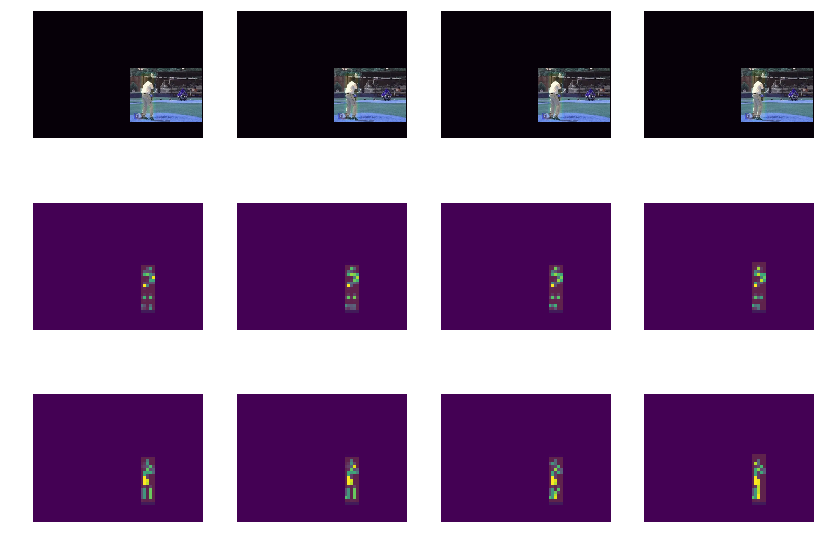

-82.0 -61.5
-10.5 -7.5
-10.5 -7.5
-10.5 -7.5
-10.5 -7.5


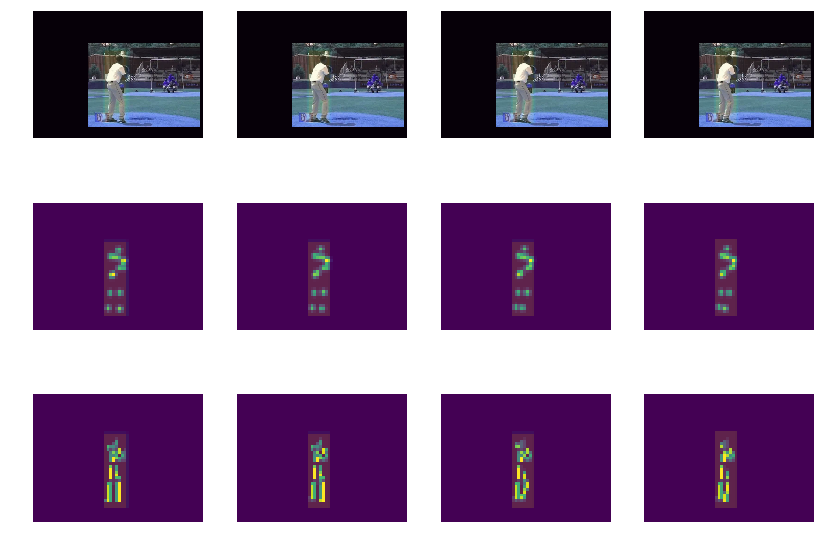

-156.5 -117.5
-19.5 -14.5
-19.5 -14.5
-19.5 -14.5
-19.5 -14.5


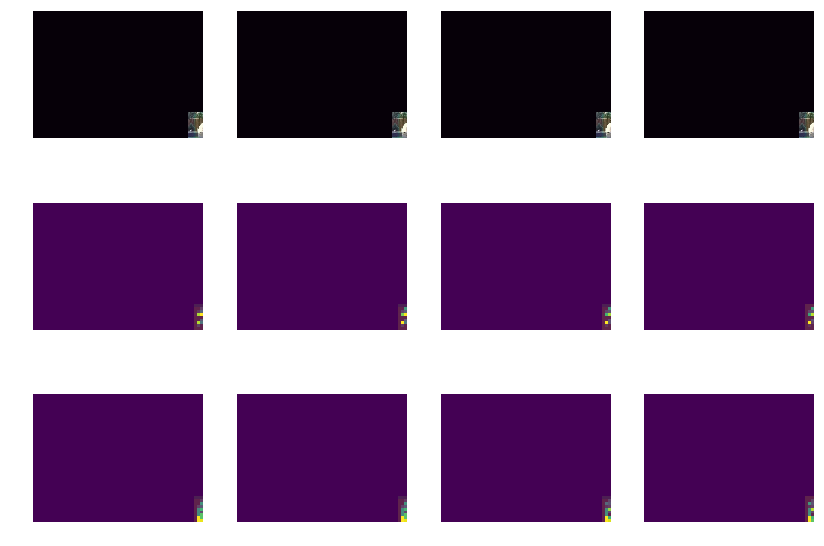

-11.5 -9.0
-1.5 -1.0
-1.5 -1.0
-1.5 -1.0
-1.5 -1.0


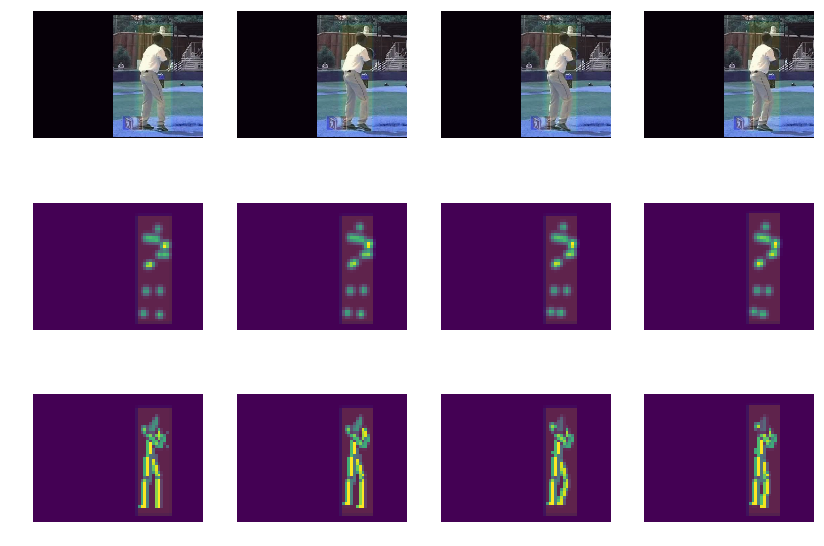

-97.0 -73.0
-12.0 -9.0
-12.0 -9.0
-12.0 -9.0
-12.0 -9.0


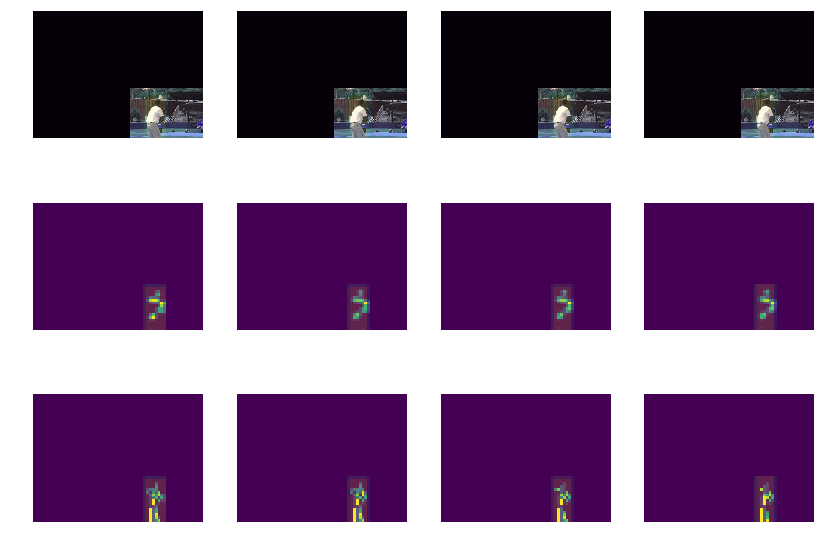

-68.5 -51.5
-8.5 -6.5
-8.5 -6.5
-8.5 -6.5
-8.5 -6.5


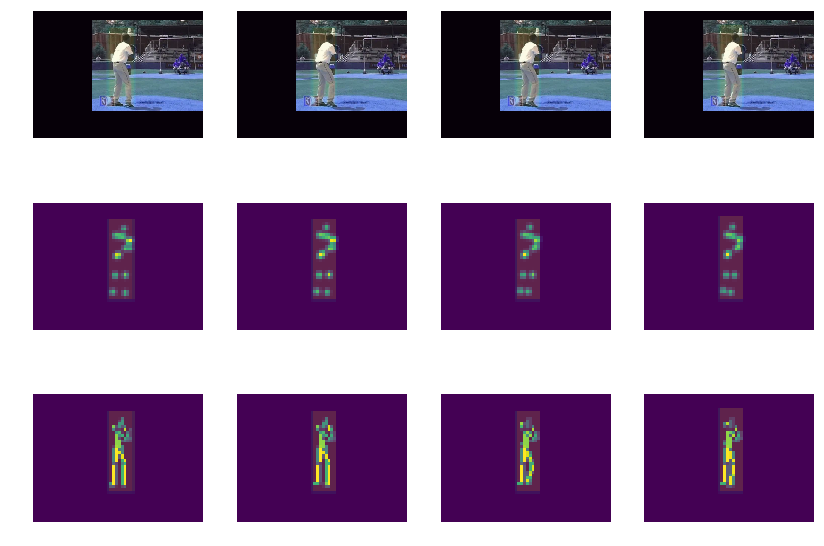

-60.5 -45.5
-7.5 -5.5
-7.5 -5.5
-7.5 -5.5
-7.5 -5.5


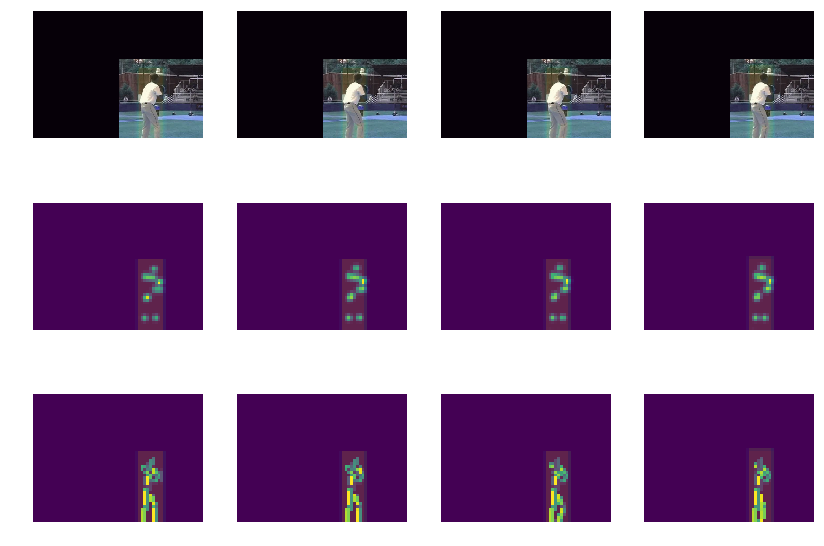

-136.0 -102.0
-17.0 -12.5
-17.0 -12.5
-17.0 -12.5
-17.0 -12.5


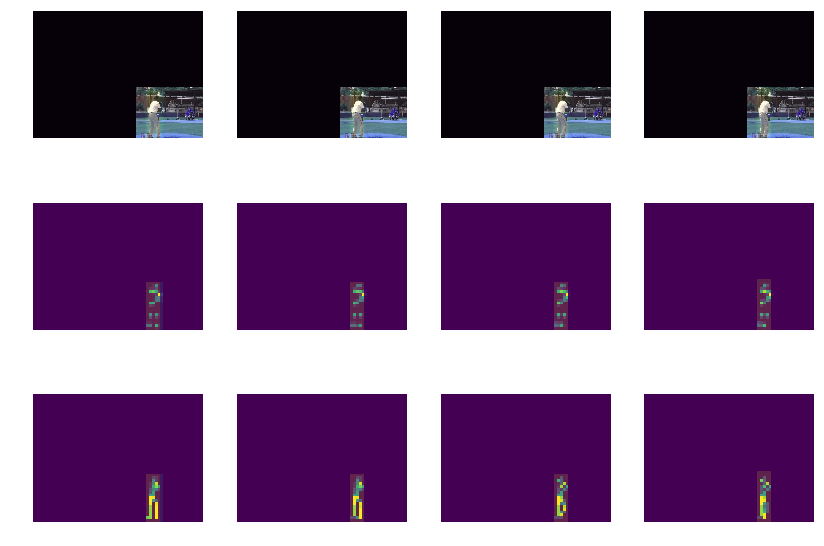

-2.0 -1.5
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


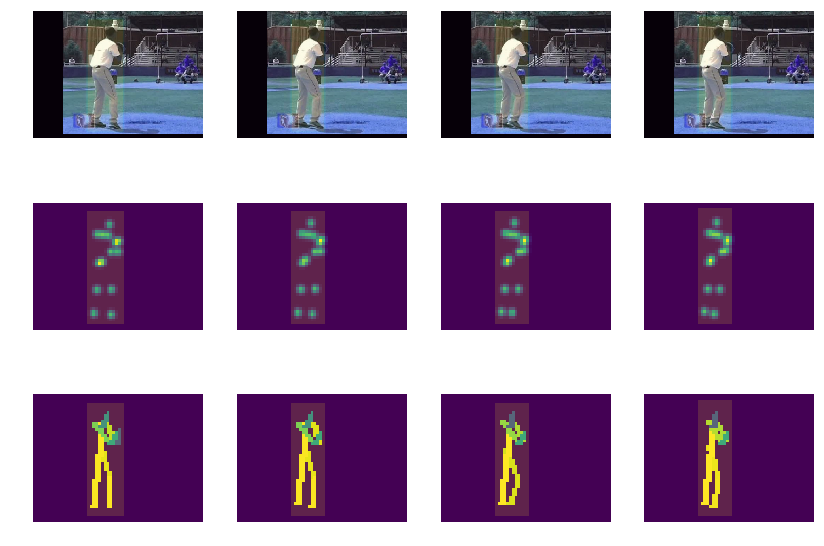

-82.0 -61.5
-10.0 -7.5
-10.0 -7.5
-10.0 -7.5
-10.0 -7.5


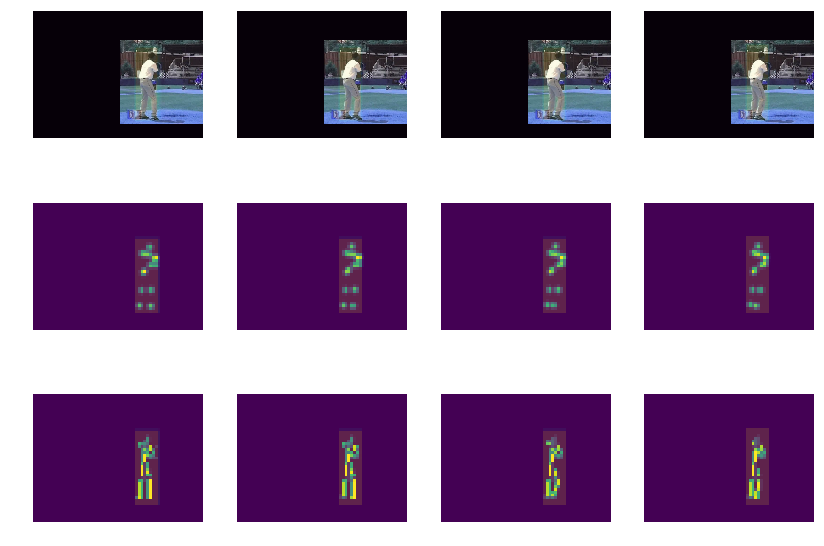

In [10]:
import matplotlib.pyplot as plt

for tag in range(10):
    (frames, mask_pafs, mask_heats), (pafs, heats) = next_video_batch(dset, 1, stop=True)

    FIRST = 0
    SEQ = 4
    plt.figure(figsize=(14, 10))

    for ii in range(SEQ):
        plt.subplot(3, SEQ, ii+1)
        plt.axis('off')
        img = frames[FIRST][ii].astype(np.float32)/256
        plt.imshow(img)
        msk = cv2.resize(mask_heats[FIRST][ii][:, :, FIRST], (0,0), fx=8, fy=8)
        plt.imshow(msk, alpha=0.1, vmin=0, vmax=1)

    for ii in range(SEQ):
        plt.subplot(3, SEQ, SEQ+ii+1)
        plt.axis('off')
        img = np.sum(heats[FIRST][ii][:, :, :-1], axis=-1).astype(np.float32)
        plt.imshow(img)
        plt.imshow(mask_heats[FIRST][ii][:, :, FIRST], alpha=0.15)

    for ii in range(SEQ):
        plt.subplot(3, SEQ, 2*SEQ+ii+1)
        plt.axis('off')
        sy, sx, _ = pafs[FIRST][ii].shape
        canvas = np.zeros((sy, sx))
        for dd in range(38):
            plane = pafs[FIRST][ii][:, :, dd]
            canvas[plane > 0] = plane[plane > 0]
        img = canvas.astype(np.float32)
        plt.imshow(img)
        plt.imshow(mask_heats[FIRST][ii][:, :, FIRST], alpha=0.15)

    plt.show()
    plt.close